# Introduction

<div class="alert alert-warning">
<font color=black>

**What?** How do add early stopping in PyTorch

</font>
</div>

# Import modules

In [1]:

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
# Custom-made class
from PyTorchTools import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from numpy.random import seed
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Getting a test function

<div class="alert alert-info">
<font color=black>

- Neural networks are sometimes described as a **universal function approximator**. 
- In this notebook we'll use a complex enough function and we'll build an MPL network using Keras and PyTorch

</font>
</div>

In [2]:
x = np.linspace(0, 10, 500)
y = np.sin(x)
yNoise = np.sin(x) + np.random.normal(0, 0.1, len(x))

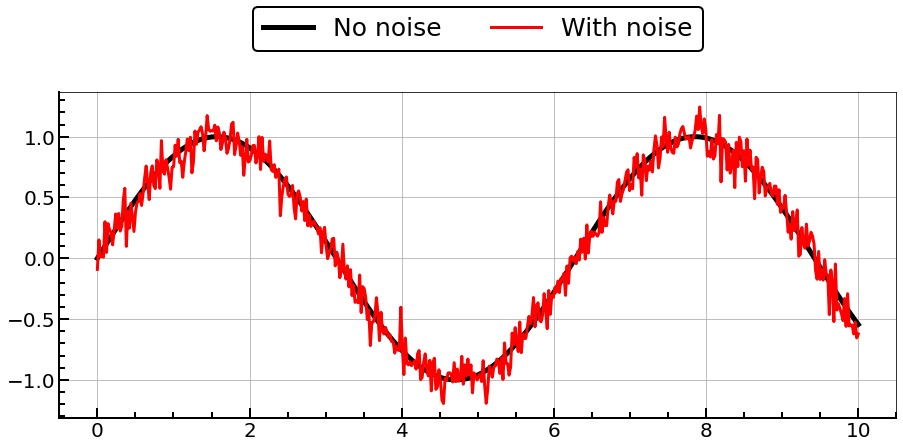

In [3]:
rcParams['font.size'] = 20
rcParams['figure.figsize'] = 15, 6

fig = plt.figure() 
ax = fig.add_subplot(111) 

plt.plot(x, y, "k-", lw = 5, label = "No noise")
plt.plot(x, yNoise, "r-", lw = 3, label = "With noise")
#plt.plot(xx, yy, "m-", lw = 3)

ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.grid()
ax.minorticks_on()

legendObject = ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.3),
          ncol = 2, fontsize = 25, fancybox = True, shadow = False,
          facecolor = "w", framealpha = 1)
legendObject.get_frame().set_linewidth(2.0)
legendObject.get_frame().set_edgecolor("k")

plt.show();

# Splitting the dataset

<div class="alert alert-info">
<font color=black>

- Good practice: set = train + test + validation
- In practice (not so good practice): set = train + test
- The question is: **while using early stopping, shall I use test or validation method?** If we are using early stopping as a training termination criterion then it becomes part of your learning algorithm, meaning the model is implicitly seen these data. Thus this data cannot be used for testing otherwise you are leaking info when you are not supposed to.

    
- While practicing you'll see that is difficult to see this leakage and people simply do not bother with it.
- There are cases where you **simply cannot have** all three sets and then you have to rely on other validation methods such as a cross validation etc.

</font>
</div>

In [4]:
X_test, X_, y_test, y_ = train_test_split(x, yNoise,
                                                    test_size = 0.8, 
                                                    random_state = 7, 
                                                    shuffle = True)

X_valid, X_train, y_valid, y_train = train_test_split(X_, y_,
                                                    test_size = 0.8, 
                                                    random_state = 7, 
                                                    shuffle = True)

print("Checking TRAIN set dimensions: ", len(X_train), len(y_train))
print("Checking VALIDATION set dimensions: ", len(X_valid), len(y_valid))
print("Checking TEST set dimensions: ", len(X_test), len(y_test))
print("Checking ORIGINAL dimensions: ", len(x), len(y))

Checking TRAIN set dimensions:  320 320
Checking VALIDATION set dimensions:  80 80
Checking TEST set dimensions:  100 100
Checking ORIGINAL dimensions:  500 500


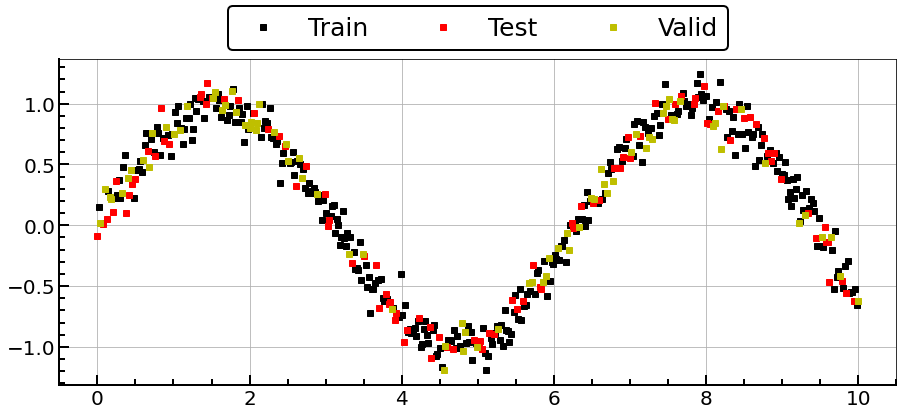

In [5]:
rcParams['font.size'] = 20
rcParams['figure.figsize'] = 15, 6

fig = plt.figure() 
ax = fig.add_subplot(111) 

plt.plot(X_train, y_train, "ks", lw = 5, label = "Train")
plt.plot(X_test, y_test, "rs", lw = 3, label = "Test")
plt.plot(X_valid, y_valid, "ys", lw = 3, label = "Valid")

ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.grid()
ax.minorticks_on()

legendObject = ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.2),
          ncol = 3, fontsize = 25, fancybox = True, shadow = False,
          facecolor = "w", framealpha = 1)
legendObject.get_frame().set_linewidth(2.0)
legendObject.get_frame().set_edgecolor("k")

plt.show();

# Input preparation

<div class="alert alert-info">
<font color=black>

- In this section we're preparing the data to be ingested by the two frameworks.
- **Keras** (`_K`) accepts `numpy.ndarray`
- **PyTorch** (`_PT`) is a bit more picky and you have to use `Variable()` which return a tensor. Make sure you pass a 2D numpy.ndarray to `Variable`, you can do this by using `reshape()`

</font>
</div>

In [6]:
def createPTdataLoader(X,y):
    """Create PyTorch data loader
    
    X np.ndarray
        Feature vector/matrix
    y np.ndarray
        target(s)
    """
    
    # From numpy to torch tensor
    x = torch.from_numpy(X)
    y = torch.from_numpy(y)
    print(x.shape, y.shape)

    # 2D dimensinal input
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    print(x.shape, y.shape)

    # PyTorch can only train on Variable
    x, y = Variable(x.float()), Variable(y.float())
    print(x.shape, y.shape)
    print(type(x), type(y))

    torch_dataset = Data.TensorDataset(x, y)

    # Split data in batches
    loader = Data.DataLoader(
        dataset = torch_dataset, 
        batch_size = 64, 
        shuffle = True, 
        num_workers = 2)
    
    return loader, x, y

In [7]:
loader_train, xPT_train, yPT_train = createPTdataLoader(X_train, y_train)
loader_valid, xPT_valid, yPT_valid = createPTdataLoader(X_valid, y_valid)
loader_test, xPT_test, yPT_test = createPTdataLoader(X_test, y_test)

torch.Size([320]) torch.Size([320])
torch.Size([320, 1]) torch.Size([320, 1])
torch.Size([320, 1]) torch.Size([320, 1])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([80]) torch.Size([80])
torch.Size([80, 1]) torch.Size([80, 1])
torch.Size([80, 1]) torch.Size([80, 1])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([100]) torch.Size([100])
torch.Size([100, 1]) torch.Size([100, 1])
torch.Size([100, 1]) torch.Size([100, 1])
<class 'torch.Tensor'> <class 'torch.Tensor'>


# Model architecture

<div class="alert alert-info">
<font color=black>

- This is where the MLP architecture get define.
- Essentially rhis were the layer get stack together.
- It is eveident the similarity btw the two framework and the phylosophy behind the `Sequential`.
- You will see that the specific way we have gone to build the network was due to fact we had to find a way to build in a loop.

</font>
</div>

## PyTorch

<div class="alert alert-info">
<font color=black>

**Method No1**<br>
`
model_PT = torch.nn.Sequential(
        torch.nn.Linear(1, 200),
        torch.nn.ReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 1),
)
`

**Method No2**<br>
`
layers = []
layers.append(torch.nn.Linear(1, 200))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(200, 100))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(100, 1))
model_PT = nn.Sequential(*layers)
`

- Method #1 is totally equivalent to Method #2
- We are going to use the second method as it allows to build it in a loop.

</font>
</div>

In [8]:
torch.manual_seed(1)

layers = []
layers.append(torch.nn.Linear(1, 200))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(200, 100))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(100, 1))
model_PT = nn.Sequential(*layers)

optimizer = torch.optim.Adam(model_PT.parameters(), lr = 0.01)
# MSE is the mean squared loss
loss_func = torch.nn.MSELoss()

early_stopping_PT = EarlyStopping(patience = 50, delta = 0.001)

# Training

In [9]:
# Start training
train_lossHistory_PT = []
valid_lossHistory_PT = []
train_losses = []
valid_losses = []

for epoch in range(1000):    
    
    #----Training loop----
    #model_PT.train()
    for step, (batch_x, batch_y) in enumerate(loader_train):
                
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)    
                
        # Input x and predict based on x
        prediction = model_PT(b_x)    
        # Must be (1. nn output, 2. target)
        loss = loss_func(prediction, b_y)     

        # Clear gradients for next train
        optimizer.zero_grad()   
        # Backpropagation, compute gradients
        loss.backward()         
        # Apply gradients
        optimizer.step()                
        # Record training loss
        currentBatchLoss = loss.item() 
        train_losses.append(currentBatchLoss)        
    
    #----Validation loop----
    #model_PT.eval()
    for batch_x, batch_y in loader_valid:
                
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)    
                
        # Input x and predict based on x
        prediction = model_PT(b_x)    
        # Must be (1. nn output, 2. target)
        loss = loss_func(prediction, b_y)     
                      
        # Record training loss
        currentBatchLoss = loss.item() 
        valid_losses.append(currentBatchLoss)
    
    train_loss_avr = np.average(train_losses)
    train_lossHistory_PT.append(train_loss_avr)
    
    valid_loss_avr = np.average(valid_losses)
    valid_lossHistory_PT.append(valid_loss_avr)
    print("Current #", epoch, " loss", train_loss_avr, " valid_loss", valid_loss_avr)    
    
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    # initialize the early_stopping object    
    early_stopping_PT(valid_loss_avr, model_PT)

    if early_stopping_PT.early_stop:
        print("Early stopping")
        break
    

Current # 0  loss 11.070396876335144  valid_loss 2.6674596071243286
Current # 1  loss 1.549293088912964  valid_loss 0.9943442344665527
Current # 2  loss 0.6229721486568451  valid_loss 0.38428471982479095
Current # 3  loss 0.48949516415596006  valid_loss 0.3923267722129822
EarlyStopping counter: 1 out of 50
Current # 4  loss 0.47672744989395144  valid_loss 0.44521158933639526
EarlyStopping counter: 2 out of 50
Current # 5  loss 0.47113373279571535  valid_loss 0.4604732245206833
EarlyStopping counter: 3 out of 50
Current # 6  loss 0.4552879214286804  valid_loss 0.3796345889568329
Current # 7  loss 0.443399977684021  valid_loss 0.41060642898082733
EarlyStopping counter: 1 out of 50
Current # 8  loss 0.42494807839393617  valid_loss 0.3816523104906082
EarlyStopping counter: 2 out of 50
Current # 9  loss 0.400419157743454  valid_loss 0.3183477073907852
Current # 10  loss 0.38765119910240176  valid_loss 0.3869263529777527
EarlyStopping counter: 1 out of 50
Current # 11  loss 0.378689503669738

Current # 85  loss 0.118428935110569  valid_loss 0.0925733670592308
EarlyStopping counter: 12 out of 50
Current # 86  loss 0.11952152699232102  valid_loss 0.10158457607030869
EarlyStopping counter: 13 out of 50
Current # 87  loss 0.11664422452449799  valid_loss 0.11444181203842163
EarlyStopping counter: 14 out of 50
Current # 88  loss 0.11656958460807801  valid_loss 0.09566570818424225
EarlyStopping counter: 15 out of 50
Current # 89  loss 0.11448840647935868  valid_loss 0.10251059383153915
EarlyStopping counter: 16 out of 50
Current # 90  loss 0.11313037872314453  valid_loss 0.12991904094815254
EarlyStopping counter: 17 out of 50
Current # 91  loss 0.11312846541404724  valid_loss 0.12074966728687286
EarlyStopping counter: 18 out of 50
Current # 92  loss 0.11479817181825638  valid_loss 0.10583888366818428
EarlyStopping counter: 19 out of 50
Current # 93  loss 0.11093514561653137  valid_loss 0.0827475506812334
Current # 94  loss 0.1109842300415039  valid_loss 0.09926275163888931
EarlySt

Current # 166  loss 0.021898716688156128  valid_loss 0.013205285649746656
Current # 167  loss 0.020124677941203116  valid_loss 0.019552537705749273
EarlyStopping counter: 1 out of 50
Current # 168  loss 0.025067524053156376  valid_loss 0.024147719144821167
EarlyStopping counter: 2 out of 50
Current # 169  loss 0.03228965401649475  valid_loss 0.06841359473764896
EarlyStopping counter: 3 out of 50
Current # 170  loss 0.03272783122956753  valid_loss 0.023632902652025223
EarlyStopping counter: 4 out of 50
Current # 171  loss 0.020055883936583994  valid_loss 0.017522893846035004
EarlyStopping counter: 5 out of 50
Current # 172  loss 0.020367911830544472  valid_loss 0.012539282441139221
EarlyStopping counter: 6 out of 50
Current # 173  loss 0.020982800424098967  valid_loss 0.01633201679214835
EarlyStopping counter: 7 out of 50
Current # 174  loss 0.01997939720749855  valid_loss 0.0134336082264781
EarlyStopping counter: 8 out of 50
Current # 175  loss 0.022596081905066966  valid_loss 0.014256

Current # 243  loss 0.017737429402768613  valid_loss 0.020182637497782707
EarlyStopping counter: 32 out of 50
Current # 244  loss 0.020598958991467953  valid_loss 0.007634810172021389
EarlyStopping counter: 33 out of 50
Current # 245  loss 0.015270518139004707  valid_loss 0.013839476741850376
EarlyStopping counter: 34 out of 50
Current # 246  loss 0.015713177062571047  valid_loss 0.013948768377304077
EarlyStopping counter: 35 out of 50
Current # 247  loss 0.01793108694255352  valid_loss 0.009429366327822208
EarlyStopping counter: 36 out of 50
Current # 248  loss 0.014138595201075077  valid_loss 0.008764552185311913
EarlyStopping counter: 37 out of 50
Current # 249  loss 0.012229335121810436  valid_loss 0.009206725284457207
EarlyStopping counter: 38 out of 50
Current # 250  loss 0.014292212575674057  valid_loss 0.021030143834650517
EarlyStopping counter: 39 out of 50
Current # 251  loss 0.015821167267858982  valid_loss 0.014772425405681133
EarlyStopping counter: 40 out of 50
Current # 2

# Post-process the results

<div class="alert alert-info">
<font color=black>

- In here we are checking two things:
    - Metrics on the test set and
    - Learning curves

</font>
</div>

## Performance on the test set

In [10]:
def getMetrics(model, xSet, ySet, setName):
    """Get metrics
    
    Applied to regression problmes
    """
    
    if "keras" in setName.lower().split("_"):
        preds  = model.predict(xSet)
    else:
        preds = model(xSet).data.numpy()

    r2s  = r2_score(ySet, preds)
    mse  = mean_squared_error(ySet, preds)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(ySet, preds)

    print("[MSE]_"+str(setName)+": %.4f" % mse)
    print("[RMSE]_"+str(setName)+": %.4f"% rmse)
    print("[MAE]_"+str(setName)+": %.4f"% mae)
    print("[R2]_"+str(setName)+": %.4f"% r2s)
    print("*****************")
    

In [11]:
getMetrics(model_PT, xPT_test, yPT_test, "TEST_PT")

[MSE]_TEST_PT: 0.0160
[RMSE]_TEST_PT: 0.1266
[MAE]_TEST_PT: 0.1051
[R2]_TEST_PT: 0.9667
*****************


## Learning curves

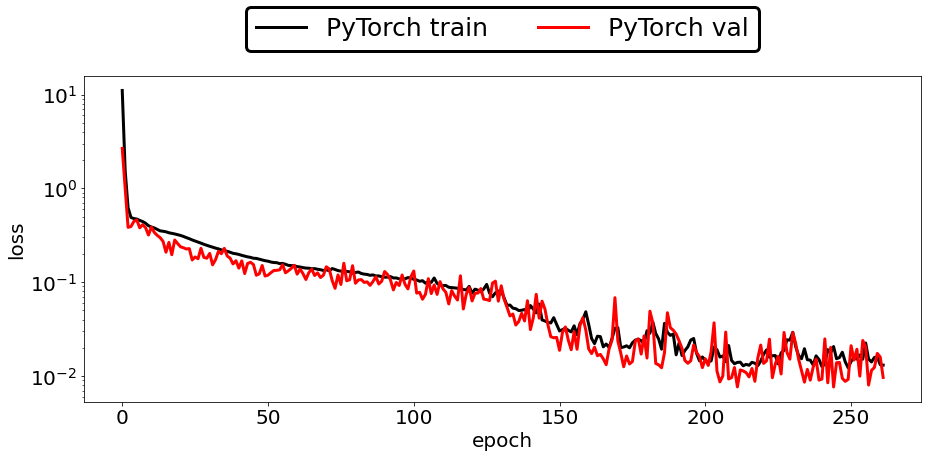

In [12]:
fig = plt.figure() 
ax = fig.add_subplot(111) 

plt.plot(range(len(train_lossHistory_PT)), train_lossHistory_PT, "k-", lw = 3, label = "PyTorch train")
plt.plot(range(len(valid_lossHistory_PT)), valid_lossHistory_PT, "r-", lw = 3, label = "PyTorch val")

plt.ylabel( "loss" )
plt.xlabel( "epoch" )
plt.yscale('log')

# How to control it in a loop (more elegant)
legendObject = ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.25),
          ncol = 2, fontsize = 25, fancybox = True, shadow = False,
          facecolor = "w", framealpha = 1)
legendObject.get_frame().set_linewidth(3.0)
legendObject.get_frame().set_edgecolor("k")

for i in range(len(legendObject.legendHandles)):
    legendObject.legendHandles[i]._sizes = [80]  

plt.show()

# Comparisons

<div class="alert alert-info">
<font color=black>

- One of the interesting things to notice is how the framework has learnt the true function and not the function + noise.
- Keep in mind that have trained, validated and tested the data on the noisy dataset.
- The denoised trend is plotted in the figure below to show how the framework has learnt to ignore the noise.

</font>
</div>

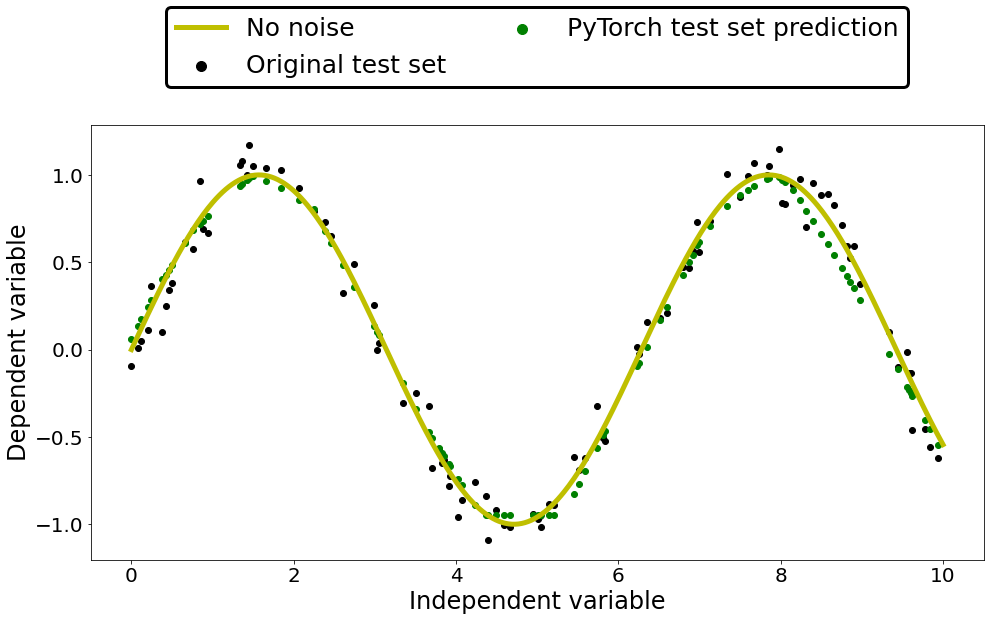

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_xlabel('Independent variable', fontsize=24)
ax.set_ylabel('Dependent variable', fontsize=24)

plt.plot(x, y, "y-", lw = 5, label = "No noise")
ax.scatter(X_test, y_test, color = "k", label = "Original test set")

prediction = model_PT(xPT_test)
ax.scatter(xPT_test.data.numpy(), prediction.data.numpy(), color='green', label = "PyTorch test set prediction")

legendObject = ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.3),
          ncol = 2, fontsize = 25, fancybox = True, shadow = False,
          facecolor = "w", framealpha = 1)
legendObject.get_frame().set_linewidth(3.0)
legendObject.get_frame().set_edgecolor("k")



for i in range(len(legendObject.legendHandles)):
    legendObject.legendHandles[i]._sizes = [100]  

plt.show()

# References

<div class="alert alert-warning">
<font color=black>

- https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379
- [nn.Sequential vs. nn.Module in PyTorch](https://discuss.pytorch.org/t/differences-between-writing-models-with-nn-sequential-vs-creating-a-class/17470)
- [Different ways to build a sequential model in PyTorch](https://stackoverflow.com/questions/46141690/how-to-write-a-pytorch-sequential-model)
- [Early stopping on val or test set?](https://stats.stackexchange.com/questions/56421/is-it-ok-to-determine-early-stopping-using-the-validation-set-in-10-fold-cross-v)
- [Early stopping in PyTorch #1](https://medium.com/analytics-vidhya/early-stopping-with-pytorch-to-restrain-your-model-from-overfitting-dce6de4081c5)
- [Early stopping in PyTorch #2](https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb)
- [`num_workers` on `DataLoader`](https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/10)
   
</font>
</div>

# Conclusions

<div class="alert alert-danger">
<font color=black>

- Early stopping can be seen as way to avoid overfitting.
- On top of it it will help you save time and stop the training just before it start to overly fit the data.

</font>
</div>